In [1]:
from collections import defaultdict

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from data import tfrecord_labeled_dataset, tfrecord_dataset, train_test_split, kfolds
from layers import SeluConv3D, SeluDense
from plot import plot_volume_animation, plot_loss_history
from config import (
    CT_0_TFRECORD,
    CT_1_TFRECORD,
    CT_2_TFRECORD,
    CT_3_TFRECORD,
    CT_4_TFRECORD,
    COVID_NEG_TFRECORD,
    COVID_POS_TFRECORD,
    SCAN_SHAPE,
    LIDC_NUM_NODULES_TFRECORD,
)

%matplotlib inline
plt.rcParams["figure.figsize"] = [15, 7]

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# LIDC dataset

In [ ]:
lidc_dataset = tfrecord_labeled_dataset(LIDC_NUM_NODULES_TFRECORD)
# lidc_samples = sum(1 for _ in tqdm(lidc_dataset))
lidc_samples = 1141
print(f"{lidc_samples = }")
lidc_dataset

In [ ]:
def build_regression_model():
    model = keras.Sequential(
        [
            keras.layers.InputLayer(SCAN_SHAPE, name="input_layer"),
            SeluConv3D(filters=32, kernel_size=3, name="selu_conv3d_1"),
            keras.layers.MaxPool3D(2, name="maxpool3d_1"),
            SeluConv3D(filters=64, kernel_size=3, name="selu_conv3d_2"),
            keras.layers.MaxPool3D(2, name="maxpool3d_2"),
            SeluConv3D(filters=128, kernel_size=3, name="selu_conv3d_3"),
            keras.layers.MaxPool3D(2, name="maxpool3d_3"),
            SeluConv3D(filters=256, kernel_size=3, name="selu_conv3d_4"),
            keras.layers.MaxPool3D(2, name="maxpool3d_4"),
            keras.layers.Flatten(name="flatten"),
            keras.layers.Dense(1, name="final_dense"),
        ],
        name="3d_cnn",
    )
    return model


m = build_regression_model()
m.summary()

In [ ]:
val_perc = 0.2
learning_rate = 1e-4
batch_size = 16
patience = 15

In [ ]:
train_dataset, val_dataset = train_test_split(
    lidc_dataset, test_perc=val_perc, cardinality=lidc_samples
)
val_dataset = (
    val_dataset.cache().batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
)
train_dataset = (
    train_dataset.cache()  # must be called before shuffle
    .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
    .batch(batch_size)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

cnn = build_regression_model()
cnn.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=keras.losses.MeanSquaredError(),
)
history = cnn.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=1000,
    verbose=1,
    callbacks=[
        keras.callbacks.ModelCheckpoint(
            "models/lidc-num-3d-cnn.h5",
            monitor="val_loss",
            save_best_only=True,
            verbose=1,
        ),
        keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=patience,
            restore_best_weights=True,
        ),
    ],
)

In [ ]:
plot_loss_history(history)
plt.savefig("num-nodules-regression-loss.pdf")

In [ ]:
cnn = keras.models.load_model("models/lidc-num-3d-cnn.h5")
for x, y in val_dataset.unbatch().batch(1).take(10).as_numpy_iterator():
    print(f"real: {y}")
    print(f"predicted: {cnn(x, training=False).numpy()}")
    print()

# Covid dataset

In [3]:
neg_x = tfrecord_dataset(COVID_NEG_TFRECORD)
# neg_samples = sum(1 for _ in tqdm(neg_x))
neg_samples = 254  # covid_neg only
print(f"{neg_samples = }")
neg_dataset = tf.data.Dataset.zip(
    (neg_x, tf.data.Dataset.from_tensor_slices(np.int8([[0]])).repeat(neg_samples))
)
assert sum(1 for _ in neg_dataset) == neg_samples

pos_x = tfrecord_dataset(COVID_POS_TFRECORD)
# pos_samples = sum(1 for _ in tqdm(pos_x))
pos_samples = 856  # covid pos
# pos_x = pos_x.shard(3, index=0)
# pos_samples = sum(1 for _ in pos_x)
print(f"{pos_samples = }")
pos_dataset = tf.data.Dataset.zip(
    (pos_x, tf.data.Dataset.from_tensor_slices(np.int8([[1]])).repeat(pos_samples))
)
assert sum(1 for _ in pos_dataset) == pos_samples

covid_dataset = neg_dataset.concatenate(pos_dataset)
covid_samples = neg_samples + pos_samples
assert sum(1 for _ in covid_dataset) == covid_samples
print(f"{covid_samples = }")
covid_dataset

neg_samples = 254
pos_samples = 856
covid_samples = 1110


<ConcatenateDataset shapes: ((None, None, None, None), (1,)), types: (tf.float32, tf.int8)>

In [4]:
def build_3d_cnn():
    model = keras.Sequential(
        [
            keras.layers.InputLayer(SCAN_SHAPE, name="input_layer"),
            SeluConv3D(filters=32, kernel_size=3, name="selu_conv3d_1"),
            keras.layers.MaxPool3D(4, name="maxpool3d_1"),
            SeluConv3D(filters=64, kernel_size=3, name="selu_conv3d_2"),
            keras.layers.MaxPool3D(4, name="maxpool3d_2"),
            SeluConv3D(filters=128, kernel_size=3, name="selu_conv3d_3"),
            keras.layers.MaxPool3D(2, name="maxpool3d_3"),
            keras.layers.Flatten(name="flatten"),
            SeluDense(512, name="selu_dense"),
            keras.layers.AlphaDropout(0.5, name="alpha_dropout"),
            keras.layers.Dense(1, activation="sigmoid", name="final_dense"),
        ],
        name="3d_cnn",
    )
    return model


m = build_3d_cnn()
m.summary()

Model: "3d_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
selu_conv3d_1 (Conv3D)       (None, 64, 192, 224, 32)  896       
_________________________________________________________________
maxpool3d_1 (MaxPooling3D)   (None, 16, 48, 56, 32)    0         
_________________________________________________________________
selu_conv3d_2 (Conv3D)       (None, 16, 48, 56, 64)    55360     
_________________________________________________________________
maxpool3d_2 (MaxPooling3D)   (None, 4, 12, 14, 64)     0         
_________________________________________________________________
selu_conv3d_3 (Conv3D)       (None, 4, 12, 14, 128)    221312    
_________________________________________________________________
maxpool3d_3 (MaxPooling3D)   (None, 2, 6, 7, 128)      0         
_________________________________________________________________
flatten (Flatten)            (None, 10752)             0    

In [5]:
def build_pretrained_3d_cnn(freeze_conv_layers=True):
    pretrained_3d_cnn = keras.models.load_model("models/lidc-num-3d-cnn.h5")
    if freeze_conv_layers:
        for layer in pretrained_3d_cnn.layers:
            if "conv" in layer.name:
                layer.trainable = False
    pretrained_3d_cnn.pop()  # remove last dense layer
    return keras.Sequential(
        [
            keras.layers.InputLayer(SCAN_SHAPE, name="pretrained_input"),
            pretrained_3d_cnn,
            keras.layers.Dense(1, activation="sigmoid", name="final_dense"),
        ],
        name="pretrained_3d_cnn",
    )


m = build_pretrained_3d_cnn()
m.summary()

Model: "pretrained_3d_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
3d_cnn (Sequential)          (None, 172032)            1162560   
_________________________________________________________________
final_dense (Dense)          (None, 1)                 172033    
Total params: 1,334,593
Trainable params: 172,033
Non-trainable params: 1,162,560
_________________________________________________________________


In [ ]:
test_perc = 0.1
val_perc = 0.1
learning_rate = 1e-5
batch_size = 16
patience = 15

In [ ]:
trainval_dataset, test_dataset = train_test_split(
    covid_dataset, test_perc=test_perc, cardinality=covid_samples
)
train_dataset, val_dataset = train_test_split(trainval_dataset, test_perc=val_perc)
test_dataset = test_dataset.batch(1)
val_dataset = (
    val_dataset.cache().batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
)
train_dataset = (
    train_dataset.cache()  # must be called before shuffle
    .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
    .batch(batch_size)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

cnn = build_3d_cnn()
# cnn = build_pretrained_3d_cnn(True)
cnn.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[
        keras.metrics.TruePositives(name="tp"),
        keras.metrics.FalsePositives(name="fp"),
        keras.metrics.TrueNegatives(name="tn"),
        keras.metrics.FalseNegatives(name="fn"),
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
        keras.metrics.AUC(name="auc"),
        keras.metrics.BinaryAccuracy(name="accuracy"),
    ],
)
history = cnn.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=1000,
    verbose=1,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=patience,
            restore_best_weights=True,
        ),
    ],
)

In [ ]:
print(cnn.evaluate(test_dataset, return_dict=True))
plot_loss_history(history)

In [16]:
rounds = 10
fracs = (1, 2, 5, 7, 10, 15, 20)
test_perc = 0.1
# val_perc = 0.1
learning_rate = 1e-5
batch_size = 8
# patience = 10
# num_epochs = 1000
metrics = [
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
    keras.metrics.AUC(name="auc", num_thresholds=1000),
]

In [17]:
data = defaultdict(list)
wo_pt_histories = []
w_pt_histories = []
for r in tqdm(range(rounds)):
    print(f" {r = } ")
    full_train_dataset, test_dataset = train_test_split(
        covid_dataset, test_perc=test_perc, cardinality=covid_samples
    )
    # print(f"Test size: {sum(1 for _ in test_dataset)}")
    test_dataset = test_dataset.batch(batch_size)
    # full_train_dataset, val_dataset = train_test_split(
    #     trainval_dataset, test_perc=val_perc
    # )
    # print(f"Val size: {sum(1 for _ in val_dataset)}")
    # val_dataset = val_dataset.batch(batch_size)
    wo_pt_frac_histories = []
    w_pt_frac_histories = []
    for frac in fracs:
        print(f" {frac = } ")
        train_dataset = (
            full_train_dataset.shuffle(1024, reshuffle_each_iteration=False)
            .shard(num_shards=frac, index=0)
            .cache()  # must be called before shuffle
            .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
            .batch(batch_size)
            .prefetch(tf.data.experimental.AUTOTUNE)
        )
        # print(f"Train size: {sum(1 for _ in train_dataset.unbatch())}")

        cnn = build_3d_cnn()
        cnn.compile(
            optimizer=keras.optimizers.Adam(learning_rate),
            loss=keras.losses.BinaryCrossentropy(),
            metrics=metrics,
        )
        history = cnn.fit(
            train_dataset,
            # validation_data=val_dataset,
            epochs=10,
            verbose=0,
            # callbacks=[
            #    keras.callbacks.EarlyStopping(
            #        monitor="val_loss",
            #        patience=patience,
            #        restore_best_weights=True,
            #    )
            # ],
        )
        wo_pt_frac_histories.append(history)
        test_metrics = cnn.evaluate(test_dataset, return_dict=True, verbose=False)
        wo_pt_auc = test_metrics["auc"]
        print(f"{wo_pt_auc = }")
        wo_pt_precision = test_metrics["precision"]
        print(f"{wo_pt_precision = }")
        wo_pt_recall = test_metrics["recall"]
        print(f"{wo_pt_recall = }")

        cnn = build_pretrained_3d_cnn(True)
        cnn.compile(
            optimizer=keras.optimizers.Adam(learning_rate),
            loss=keras.losses.BinaryCrossentropy(),
            metrics=metrics,
        )
        history = cnn.fit(
            train_dataset,
            # validation_data=val_dataset,
            epochs=10,
            verbose=0,
            # callbacks=[
            #     keras.callbacks.EarlyStopping(
            #         monitor="val_loss",
            #         patience=patience,
            #         restore_best_weights=True,
            #     )
            # ],
        )
        w_pt_frac_histories.append(history)
        test_metrics = cnn.evaluate(test_dataset, return_dict=True, verbose=False)
        w_pt_auc = test_metrics["auc"]
        print(f"{w_pt_auc = }")
        w_pt_precision = test_metrics["precision"]
        print(f"{w_pt_precision = }")
        w_pt_recall = test_metrics["recall"]
        print(f"{w_pt_recall = }")

        data["train_size_fraction"].append(frac)
        data["metric"].append("AUC difference")
        data["metric_value"].append(w_pt_auc - wo_pt_auc)
        data["train_size_fraction"].append(frac)
        data["metric"].append("precision difference")
        data["metric_value"].append(w_pt_precision - wo_pt_precision)
        data["train_size_fraction"].append(frac)
        data["metric"].append("recall difference")
        data["metric_value"].append(w_pt_recall - wo_pt_recall)

    wo_pt_histories.append(wo_pt_frac_histories)
    w_pt_histories.append(w_pt_frac_histories)

 r = 0 
 frac = 1 
wo_pt_auc = 0.780765950679779
wo_pt_precision = 0.7477477192878723
wo_pt_recall = 1.0
w_pt_auc = 0.757530152797699
w_pt_precision = 0.7835051417350769
w_pt_recall = 0.9156626462936401
 frac = 2 
wo_pt_auc = 0.7555938363075256
wo_pt_precision = 0.7477477192878723
wo_pt_recall = 1.0
w_pt_auc = 0.7874354720115662
w_pt_precision = 0.7647058963775635
w_pt_recall = 0.9397590160369873
 frac = 5 
wo_pt_auc = 0.7228915691375732
wo_pt_precision = 0.7477477192878723
wo_pt_recall = 1.0
w_pt_auc = 0.6927710771560669
w_pt_precision = 0.78125
w_pt_recall = 0.9036144614219666
 frac = 7 
wo_pt_auc = 0.739242672920227
wo_pt_precision = 0.7477477192878723
wo_pt_recall = 1.0
w_pt_auc = 0.6465146541595459
w_pt_precision = 0.7641509175300598
w_pt_recall = 0.9759036302566528
 frac = 10 
wo_pt_auc = 0.7287005186080933
wo_pt_precision = 0.7523809671401978
wo_pt_recall = 0.9518072009086609
w_pt_auc = 0.6488813161849976
w_pt_precision = 0.7666666507720947
w_pt_recall = 0.8313252925872803
 frac

wo_pt_auc = 0.53125
wo_pt_precision = 0.7117117047309875
wo_pt_recall = 1.0
w_pt_auc = 0.48556169867515564
w_pt_precision = 0.7300000190734863
w_pt_recall = 0.9240506291389465
 r = 6 
 frac = 1 
wo_pt_auc = 0.6406643986701965
wo_pt_precision = 0.7592592835426331
wo_pt_recall = 1.0
w_pt_auc = 0.686290979385376
w_pt_precision = 0.7547169923782349
w_pt_recall = 0.9756097793579102
 frac = 2 
wo_pt_auc = 0.6295206546783447
wo_pt_precision = 0.7387387156486511
wo_pt_recall = 1.0
w_pt_auc = 0.6719932556152344
w_pt_precision = 0.7647058963775635
w_pt_recall = 0.9512194991111755
 frac = 5 
wo_pt_auc = 0.6015560030937195
wo_pt_precision = 0.7475728392601013
wo_pt_recall = 0.9390243887901306
w_pt_auc = 0.5826324820518494
w_pt_precision = 0.7431192398071289
w_pt_recall = 0.9878048896789551
 frac = 7 
wo_pt_auc = 0.5838940143585205
wo_pt_precision = 0.7387387156486511
wo_pt_recall = 1.0
w_pt_auc = 0.5237594842910767
w_pt_precision = 0.7333333492279053
w_pt_recall = 0.9390243887901306
 frac = 10 
wo

wo_pt_auc = 0.5541208982467651
wo_pt_precision = 0.8198198080062866
wo_pt_recall = 1.0
w_pt_auc = 0.7032967209815979
w_pt_precision = 0.8735632300376892
w_pt_recall = 0.8351648449897766
 frac = 20 
wo_pt_auc = 0.7123626470565796
wo_pt_precision = 0.8198198080062866
wo_pt_recall = 1.0
w_pt_auc = 0.4961538314819336
w_pt_precision = 0.8130841255187988
w_pt_recall = 0.9560439586639404
 r = 12 
 frac = 1 
wo_pt_auc = 0.651646077632904
wo_pt_precision = 0.7297297120094299
wo_pt_recall = 1.0
w_pt_auc = 0.6563785672187805
w_pt_precision = 0.737864077091217
w_pt_recall = 0.9382715821266174
 frac = 2 
wo_pt_auc = 0.616460919380188
wo_pt_precision = 0.7297297120094299
wo_pt_recall = 1.0
w_pt_auc = 0.5903291702270508
w_pt_precision = 0.7469879388809204
w_pt_recall = 0.7654321193695068
 frac = 5 
wo_pt_auc = 0.5549382567405701
wo_pt_precision = 0.7297297120094299
wo_pt_recall = 1.0
w_pt_auc = 0.573662519454956
w_pt_precision = 0.7604166865348816
w_pt_recall = 0.9012345671653748
 frac = 7 
wo_pt_auc

KeyboardInterrupt: 

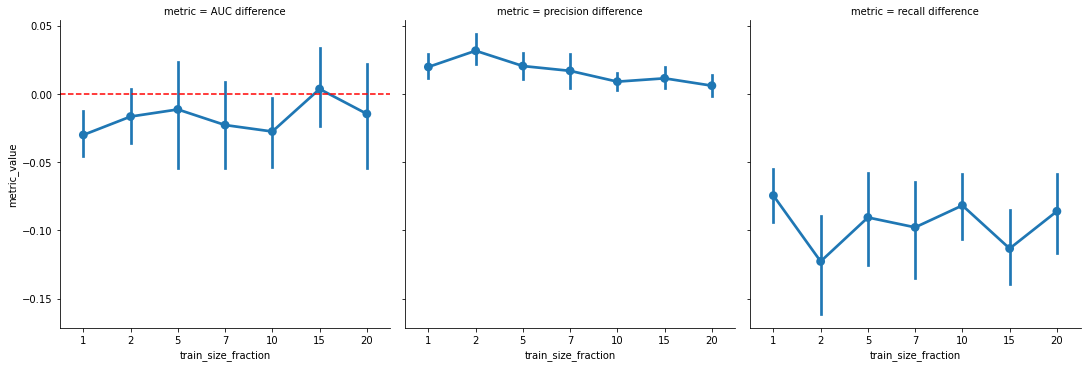

In [32]:
g = sns.catplot(
    x="train_size_fraction",
    y="metric_value",
    col="metric",
    kind="point",
    data=pd.DataFrame(data),
)
for ax in g.axes[0]:
    ax.axhline(color="r", ls="--")

KeyError: 'val_loss'

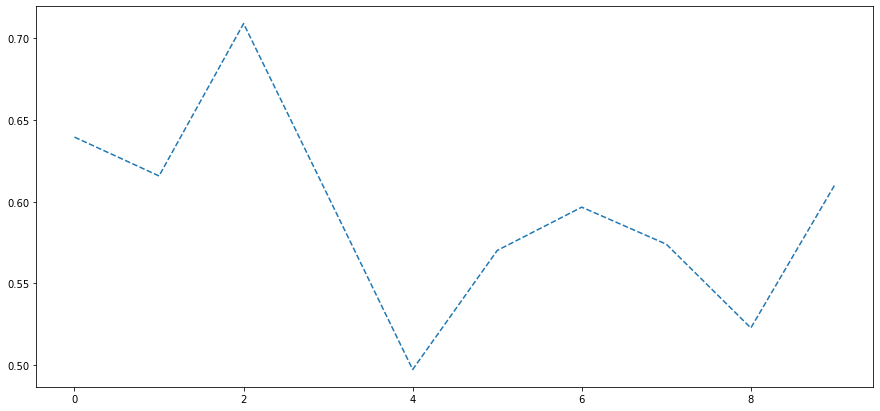

In [15]:
round_index = 3
frac_index = 4
plt.plot(
    wo_pt_histories[round_index][frac_index].history["loss"],
    "--",
    label="w/o pre-training - train loss",
)
plt.plot(
    wo_pt_histories[round_index][frac_index].history["val_loss"],
    label="w/o pre-training - val loss",
)
plt.plot(
    w_pt_histories[round_index][frac_index].history["loss"],
    "--",
    label="w/ pre-training, w/ conv freezing - train loss",
)
plt.plot(
    w_pt_histories[round_index][frac_index].history["val_loss"],
    label="w/ pre-training, w/ conv freezing - val loss",
)
plt.legend()

In [ ]:
data = defaultdict(list)
wo_pt_histories = []
w_pt_histories = []
for _ in tqdm(range(rounds)):
    trainval_dataset, test_dataset = train_test_split(
        covid_dataset, test_perc=test_perc, cardinality=covid_samples
    )
    test_dataset = test_dataset.batch(batch_size)
    full_train_dataset, val_dataset = train_test_split(
        trainval_dataset, test_perc=val_perc
    )
    val_dataset = val_dataset.batch(batch_size)
    wo_pt_frac_histories = []
    w_pt_frac_histories = []
    for frac in fracs:
        train_dataset = (
            full_train_dataset.shuffle(1024, reshuffle_each_iteration=False)
            .shard(num_shards=frac, index=0)
            .cache()  # must be called before shuffle
            .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
            .batch(batch_size)
            .prefetch(tf.data.experimental.AUTOTUNE)
        )

        cnn = build_3d_cnn()
        cnn.compile(
            optimizer=keras.optimizers.Adam(learning_rate),
            loss=keras.losses.BinaryCrossentropy(),
            metrics=metrics,
        )
        history = cnn.fit(
            train_dataset,
            validation_data=val_dataset,
            epochs=num_epochs,
            verbose=0,
            callbacks=[
                keras.callbacks.EarlyStopping(
                    monitor="val_loss",
                    patience=patience,
                    restore_best_weights=True,
                )
            ],
        )
        wo_pt_frac_histories.append(history)
        test_metrics = cnn.evaluate(test_dataset, return_dict=True, verbose=False)
        data["nn_type"].append("w/o pretraining")
        data["train_size_fraction"].append(frac)
        data["metric"].append("AUC")
        data["metric_value"].append(test_metrics["auc"])

        cnn = build_pretrained_3d_cnn(True)
        cnn.compile(
            optimizer=keras.optimizers.Adam(learning_rate),
            loss=keras.losses.BinaryCrossentropy(),
            metrics=metrics,
        )
        history = cnn.fit(
            train_dataset,
            validation_data=val_dataset,
            epochs=num_epochs,
            verbose=0,
            callbacks=[
                keras.callbacks.EarlyStopping(
                    monitor="val_loss",
                    patience=patience,
                    restore_best_weights=True,
                )
            ],
        )
        w_pt_frac_histories.append(history)
        test_metrics = cnn.evaluate(test_dataset, return_dict=True, verbose=False)
        data["nn_type"].append("w/ pretraining (conv freezing)")
        data["train_size_fraction"].append(frac)
        data["metric"].append("AUC")
        data["metric_value"].append(test_metrics["auc"])
    wo_pt_histories.append(wo_pt_frac_histories)
    w_pt_histories.append(w_pt_frac_histories)

In [ ]:
sns.catplot(
    x="train_size_fraction",
    y="metric_value",
    hue="nn_type",
    col="metric",
    kind="point",
    data=pd.DataFrame(data),
)

In [ ]:
round_index = 1
frac_index = 0
plt.plot(
    wo_pt_histories[round_index][frac_index].history["loss"],
    "--",
    label="w/o pre-training - train loss",
)
plt.plot(
    wo_pt_histories[round_index][frac_index].history["val_loss"],
    label="w/o pre-training - val loss",
)
plt.plot(
    w_pt_histories[round_index][frac_index].history["loss"],
    "--",
    label="w/ pre-training, w/ conv freezing - train loss",
)
plt.plot(
    w_pt_histories[round_index][frac_index].history["val_loss"],
    label="w/ pre-training, w/ conv freezing - val loss",
)
plt.legend()

In [ ]:
k = 10
val_perc = 0.1
learning_rate = 1e-5
batch_size = 8
patience = 10
num_epochs = 1000

In [ ]:
wo_pt_histories = []
wo_pt_metrics = [
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
    keras.metrics.AUC(name="auc", num_thresholds=1000),
    keras.metrics.BinaryAccuracy(name="accuracy"),
]
w_pt_histories = []
w_pt_metrics = [
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
    keras.metrics.AUC(name="auc", num_thresholds=1000),
    keras.metrics.BinaryAccuracy(name="accuracy"),
]
for fold_id, (train_dataset, test_dataset) in tqdm(
    enumerate(kfolds(k, covid_dataset, cardinality=covid_samples)), total=k
):
    test_dataset = test_dataset.batch(1)
    train_dataset, val_dataset = train_test_split(train_dataset, test_perc=val_perc)
    val_dataset = val_dataset.batch(batch_size)
    train_dataset = (
        train_dataset.cache()  # must be called before shuffle
        .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
        .batch(batch_size)
        .prefetch(tf.data.experimental.AUTOTUNE)
    )

    cnn = build_3d_cnn()
    cnn.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.BinaryCrossentropy(),
    )
    history = cnn.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=num_epochs,
        verbose=1,
        callbacks=[
            keras.callbacks.EarlyStopping(
                monitor="val_loss",
                patience=patience,
                restore_best_weights=True,
            )
        ],
    )
    wo_pt_histories.append(history)
    for test_x, test_y in test_dataset.as_numpy_iterator():
        pred_y = cnn(test_x, training=False)
        for metric in wo_pt_metrics:
            metric.update_state(test_y, pred_y)

    cnn = build_pretrained_3d_cnn(True)
    cnn.compile(
        optimizer=keras.optimizers.Adam(1e-5),
        loss=keras.losses.BinaryCrossentropy(),
    )
    history = cnn.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=num_epochs,
        verbose=0,
        callbacks=[
            keras.callbacks.EarlyStopping(
                monitor="val_loss",
                patience=patience,
                restore_best_weights=True,
            )
        ],
    )
    w_pt_histories.append(history)
    for test_x, test_y in test_dataset.as_numpy_iterator():
        pred_y = cnn(test_x, training=False)
        for metric in w_pt_metrics:
            metric.update_state(test_y, pred_y)

print(" total ".center(50, "="))
print("Without pretraining: ")
for metric in wo_pt_metrics:
    print(f"{metric.name}: {metric.result()}")
print("")

print("With pretraining (w/ conv freezing): ")
for metric in w_pt_metrics:
    print(f"{metric.name}: {metric.result()}")

In [ ]:
index = 0
plt.plot(
    wo_pt_histories[index].history["loss"], "--", label="w/o pre-training - train loss"
)
plt.plot(
    wo_pt_histories[index].history["val_loss"], label="w/o pre-training - val loss"
)
plt.plot(
    w_pt_histories[index].history["loss"],
    "--",
    label="w/ pre-training, w/o conv freezing - train loss",
)
plt.plot(
    w_pt_histories[index].history["val_loss"],
    label="w/ pre-training, w/o conv freezing - val loss",
)
plt.plot(
    w_pt_conv_histories[index].history["loss"],
    "--",
    label="w/ pre-training, w/ conv freezing - train loss",
)
plt.plot(
    w_pt_conv_histories[index].history["val_loss"],
    label="w/ pre-training, w/ conv freezing - val loss",
)
plt.legend()